In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import datetime
import requests
from tqdm import tqdm

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.deterministic import Fourier
from statsmodels.tsa.tsatools import add_trend
import statsmodels.api as sm
import holidays

from watermark import watermark

print(watermark())

Last updated: 2024-07-22T20:09:30.956262+03:00

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.21.0

Compiler    : GCC 14.1.1 20240622
OS          : Linux
Release     : 6.10.0-gentoo
Machine     : x86_64
Processor   : AMD Ryzen 9 5950X 16-Core Processor
CPU cores   : 32
Architecture: 64bit



## Загрузка данных

In [5]:
time_history_url = "https://deepstatemap.live/api/history/public"

In [6]:
# Making a get request
response = requests.get(time_history_url)

df = pd.DataFrame()
# print json content
t = len(response.json())
Path("data/").mkdir(exist_ok=True)
with tqdm(total=t) as pbar:
    for n, i in enumerate(response.json()):
        timestamp = i["id"]
        time_index = datetime.datetime.fromtimestamp(timestamp)
        pbar.set_description(str(time_index.date()), refresh=True)

        area = requests.get(
            f"https://deepstatemap.live/api/history/{timestamp}/areas")
        js_df = pd.json_normalize(area.json()).assign(time_index=time_index)
        df = pd.concat([df, js_df], ignore_index=True)
        pbar.update(1)
df

2024-07-21: 100%|██████████| 982/982 [06:07<00:00,  2.67it/s]


,hash,area,percent,type,time_index
0,#a52714,63864.643990,10.579,occupied_after_24_02_2022,2022-04-03 15:33:28
1,#880e4f,46937.208199,7.775,occupied_to_24_02_2022,2022-04-03 15:33:28
2,#bcaaa4,5587.522472,0.926,unspecified,2022-04-03 15:33:28
3,#0f9d58,14012.882652,2.321,liberated,2022-04-03 15:33:28
4,#a52714,63864.643990,10.579,occupied_after_24_02_2022,2022-04-03 19:46:15
...,...,...,...,...,...
4977,#bcaaa4,639.482580,0.106,unspecified,2024-07-21 23:26:28
4978,#0f9d58,42980.669305,7.120,liberated,2024-07-21 23:26:28
4979,#ff5252,139991.513798,23.189,other_territories,2024-07-21 23:26:28
4980,#880e4f,43974.128584,7.284,occupied_to_24_02_2022,2024-07-21 23:26:28


In [7]:
df.set_index("time_index", inplace=True)
df = df.astype(
    {"percent": "float32", "area": "float64", "hash": "string", "type": "category"}
)

In [8]:
df.to_csv(Path("data/area_history.csv"))

# Моделирование краткосрочного момента


In [9]:
try:
    df
except NameError:
    df = None
if df is None:
    td = (
        datetime.datetime.now().timestamp()
        - Path("data/area_history.csv").stat().st_ctime
    )
    if td >= 60 * 60 * 24:
        print("Данные устарели!")
    df = pd.read_csv(
        Path("data/area_history.csv"),
        index_col="time_index",
        parse_dates=True,
        dtype={
            "percent": "float32",
            "area": "float64",
            "hash": "string",
            "type": "category",
        },
    )

In [10]:
area_dinamic = (
    df.dropna()
    .groupby([pd.Grouper(freq="D"), "type"])[["area", "percent"]]
    .mean()
    .reset_index()
    .set_index("time_index")
)
last_date = df.index.max().strftime("%Y-%m-%d %X")

/tmp/ipykernel_17981/3457041684.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby([pd.Grouper(freq="D"), "type"])[["area", "percent"]]


In [11]:
area_dinamic.dropna(inplace=True)
area_dinamic["type"]

time_index
2022-04-03                    liberated
2022-04-03    occupied_after_24_02_2022
2022-04-03       occupied_to_24_02_2022
2022-04-03                  unspecified
2022-04-04                    liberated
                        ...            
2024-07-21                    liberated
2024-07-21    occupied_after_24_02_2022
2024-07-21       occupied_to_24_02_2022
2024-07-21            other_territories
2024-07-21                  unspecified
Name: type, Length: 3779, dtype: category
Categories (5, object): ['liberated', 'occupied_after_24_02_2022', 'occupied_to_24_02_2022', 'other_territories', 'unspecified']

In [12]:
ru_holidays = holidays.country_holidays("RU")
ua_holidays = holidays.country_holidays("UA")

In [13]:
target_area = 118370
svo_end = pd.to_datetime("2026-11-15")

In [14]:
aa = area_dinamic[area_dinamic["type"] == "occupied_after_24_02_2022"][
    "area"
]  # ["percent"]
aa = pd.DataFrame(
    index=pd.date_range(start=aa.index.min(), end=aa.index.max(), freq="D")
).join(aa)
aa.interpolate(inplace=True)
aa["prefix"] = 0
aa.loc[:"2022-11-11", "prefix"] = 1
aa

,area,prefix
2022-04-03,63714.938326,1
2022-04-04,64256.540524,1
2022-04-05,64193.626525,1
2022-04-06,64261.353774,1
2022-04-07,65046.306239,1
...,...,...
2024-07-17,65375.228426,0
2024-07-18,65383.961679,0
2024-07-19,65388.606938,0
2024-07-20,65394.081438,0


In [15]:
best_ff = None
best_aic = 99e99
for order in range(1, 3):
    for period in np.linspace(order * 2, 2 * 365.25, 100):
        fourier_gen = Fourier(period, order)
        ff = fourier_gen.in_sample(aa.index)
        ff["prefix"] = aa["prefix"]
        ff = add_trend(ff, "ct")
        model = sm.OLS(aa["area"], ff).fit()
        if best_ff is None or best_aic > model.aic:
            best_ff = model
best_ff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   area   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     710.4
Date:                Mon, 22 Jul 2024   Prob (F-statistic):          9.88e-324
Time:                        20:15:42   Log-Likelihood:                -7736.2
No. Observations:                 841   AIC:                         1.549e+04
Df Residuals:                     834   BIC:                         1.552e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
sin(1,730.50)   835.3399    154.551      5.405      0.000     531.985    1138.694
cos(1,730.50)  2773.6991    218.578     12.690      0.000    2344.672    3202.726
sin(2,730.50)  2335.0086    137.679     16.960      0.000    2064.771    2605.246
cos(2,730.50)  -584.5172    137.030     -4.266      0.000    -853.482    -315.553
prefix         2898.6660    620.577      4.671      0.000    1680.589    4116.743
const          7.195e+04    538.229    133.688      0.000    7.09e+04     7.3e+04
trend           -12.6104      0.957    -13.171      0.000     -14.490     -10.731
==============================================================================
Omnibus:                      318.009   Durbin-Watson:                   0.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2334.448
Skew:                          -1.527   Prob(JB):                         0.00
Kurtosis:                      10.569   Cond. No.                     4.90e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.9e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<Axes: >

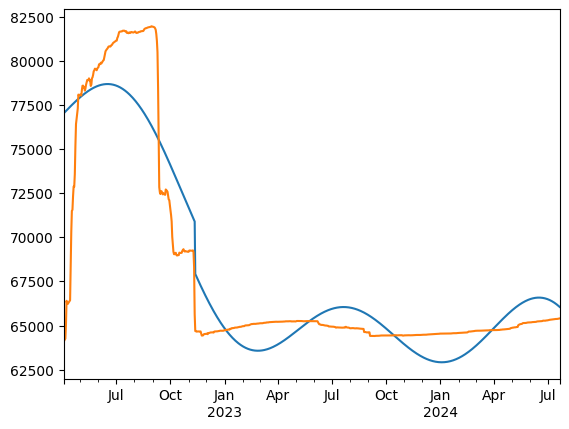

In [16]:
best_ff.predict(ff).plot()
aa["area"].plot()

In [17]:
aa.loc["2022-02-03":]

,area,prefix
2022-04-03,63714.938326,1
2022-04-04,64256.540524,1
2022-04-05,64193.626525,1
2022-04-06,64261.353774,1
2022-04-07,65046.306239,1
...,...,...
2024-07-17,65375.228426,0
2024-07-18,65383.961679,0
2024-07-19,65388.606938,0
2024-07-20,65394.081438,0


In [18]:
xx = (
    pd.DataFrame(index=aa.index).assign(
        ru_holiday=lambda x: [d in ru_holidays for d in x.index],
        ua_holiday=lambda x: [d in ua_holidays for d in x.index],
    )
).astype("int")

xx = add_trend(xx, "ct")
xx

,ru_holiday,ua_holiday,const,trend
2022-04-03,0,0,1.0,1.0
2022-04-04,0,0,1.0,2.0
2022-04-05,0,0,1.0,3.0
2022-04-06,0,0,1.0,4.0
2022-04-07,0,0,1.0,5.0
...,...,...,...,...
2024-07-17,0,0,1.0,837.0
2024-07-18,0,0,1.0,838.0
2024-07-19,0,0,1.0,839.0
2024-07-20,0,0,1.0,840.0


In [19]:
best_model = None
for p in range(6):
    for q in range(6):
        mod = ARIMA(aa["area"], order=(p, 1, q)).fit()
        if best_model is None or best_model.aic > mod.aic:
            best_model = mod
best_model.summary()

/home/v_0ver/venv/myds312/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/v_0ver/venv/myds312/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/v_0ver/venv/myds312/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/v_0ver/venv/myds312/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/v_0ver/venv/myds312/

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   area   No. Observations:                  841
Model:                 ARIMA(4, 1, 5)   Log Likelihood               -5515.785
Date:                Mon, 22 Jul 2024   AIC                          11051.570
Time:                        20:15:55   BIC                          11098.904
Sample:                    04-03-2022   HQIC                         11069.712
                         - 07-21-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1248      0.080     14.041      0.000       0.968       1.282
ar.L2         -1.0936      0.065    -16.696      0.000      -1.222      -0.965
ar.L3          1.0379      0.068     15.262      0.000       0.905       1.171
ar.L4         -0.1192      0.067     -1.789      0.074      -0.250       0.011
ma.L1         -0.3785      0.080     -4.750      0.000      -0.535      -0.222
ma.L2          0.5842      0.025     22.909      0.000       0.534       0.634
ma.L3         -0.5477      0.048    -11.424      0.000      -0.642      -0.454
ma.L4         -0.2378      0.033     -7.197      0.000      -0.303      -0.173
ma.L5         -0.2059      0.037     -5.562      0.000      -0.278      -0.133
sigma2      2.654e+04    278.017     95.479      0.000     2.6e+04    2.71e+04
===================================================================================
Ljung-Box (L1) (Q):                   7.03   Jarque-Bera (JB):            130894.08
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                            -3.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        63.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
fh = 120  # int(365.25 * 5)
fcst = best_model.get_forecast(fh, alpha=0.05).summary_frame()
fcst.index = pd.date_range(
    start=aa.index.max() + pd.DateOffset(days=1), periods=fcst.shape[0], freq="D"
)
fcst

/home/v_0ver/venv/myds312/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


area,mean,mean_se,mean_ci_lower,mean_ci_upper
2024-07-22,65410.474584,162.925416,65091.146635,65729.802532
2024-07-23,65414.579351,327.866930,64771.971977,66057.186725
2024-07-24,65417.208020,471.109079,64493.851193,66340.564847
2024-07-25,65420.221201,584.331539,64274.952430,66565.489972
2024-07-26,65423.040230,688.018841,64074.548081,66771.532379
...,...,...,...,...
2024-11-14,65501.599236,6458.616549,52842.943410,78160.255062
2024-11-15,65501.694555,6494.911715,52771.901510,78231.487600
2024-11-16,65501.781446,6531.064667,52701.129918,78302.432973
2024-11-17,65501.847446,6567.077854,52630.611369,78373.083523


In [21]:
svo_end_alpha = 99.95
svo_end_km_ration = 0.01
hh = fcst[["mean", "mean_se"]].diff() / fcst[["mean", "mean_se"]].abs()
end_svo = hh[
    (hh["mean_se"] <= 1 - svo_end_alpha /
     100) & (hh["mean"] <= svo_end_km_ration / 100)
].index.min()
fcst = fcst[:end_svo]
# fh = fcst.shape[0]
fh = 90

In [22]:
aa

,area,prefix
2022-04-03,63714.938326,1
2022-04-04,64256.540524,1
2022-04-05,64193.626525,1
2022-04-06,64261.353774,1
2022-04-07,65046.306239,1
...,...,...
2024-07-17,65375.228426,0
2024-07-18,65383.961679,0
2024-07-19,65388.606938,0
2024-07-20,65394.081438,0


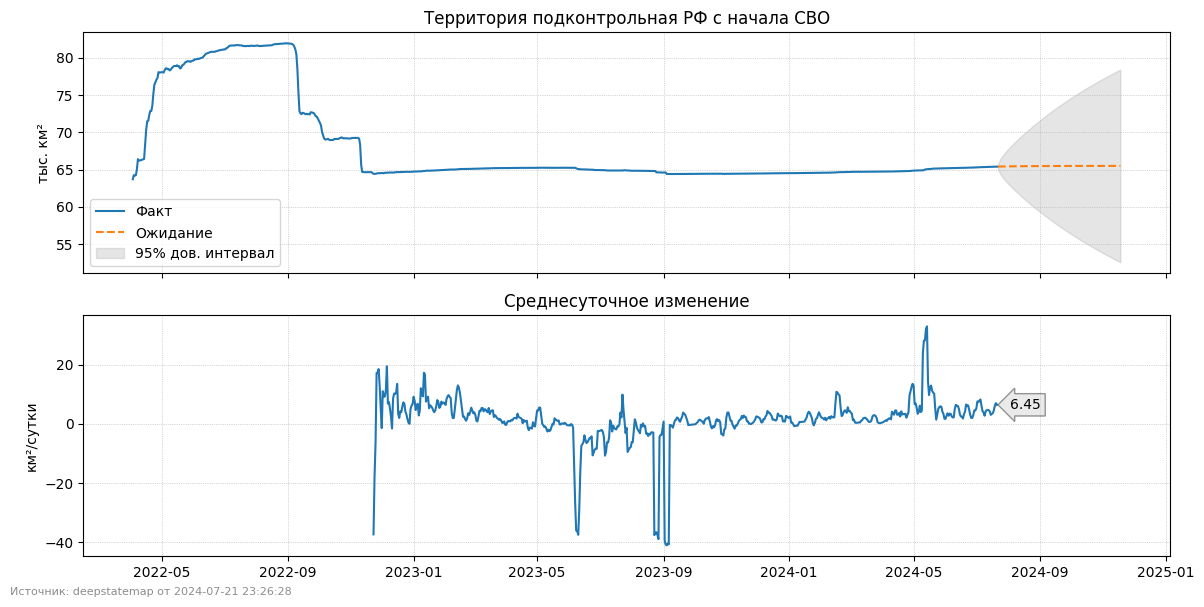

In [23]:
# sns.set_style("whitegrid")
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
ax = axs[0]
sns.lineplot(aa["area"] / 1000, ax=ax, label="Факт")
sns.lineplot(fcst["mean"] / 1000, ls="--", ax=ax, label="Ожидание")
fill_95p = ax.fill_between(
    fcst.index,
    fcst["mean_ci_lower"] / 1000,
    fcst["mean_ci_upper"] / 1000,
    alpha=0.2,
    color="grey",
)
fill_95p.set_label("95% дов. интервал")
ax.legend()
ax.set(
    xlabel=None,
    ylabel="тыс. км\u00b2",
    title="Территория подконтрольная РФ с начала СВО",
)
ax = axs[1]
ax.set(
    xlabel=None,
    ylabel="км\u00b2/сутки",
    title="Среднесуточное изменение",
)
day_din_area = (
    aa.diff()["2022-11-23":].rolling(5, center=True,
                                     min_periods=int(5 / 2)).mean()
)
sns.lineplot(
    day_din_area["area"],
    ax=ax,
    legend=None,
)
bbox = dict(boxstyle="larrow", fc="0.8", alpha=0.4)
dy = day_din_area.iloc[-1].values[0]
dx = day_din_area.index.max()
ax.annotate(
    f"{dy:.2f}",
    (dx + datetime.timedelta(days=12 + int(fh / 60)), dy),
    # xytext=(-2, 1),
    bbox=bbox,
    va="center",
    ha="left",
)
for ax in axs:
    ax.grid(ls=":", lw=0.5)
fig.tight_layout()
fig.text(
    0,
    0,
    f"Источник: deepstatemap от {last_date}",
    fontdict={"size": 8},
    alpha=0.45,
)
Path("img/").mkdir(exist_ok=True)
fig.savefig(Path("img/area.png"), format="png", dpi=300)